<a href="https://colab.research.google.com/github/farshid101/Thesis-2024/blob/main/sentiment_analysis_bangla_bert%20final_Clean%20Pro%202.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current

In [23]:
#Dataset
#https://github.com/farshid101/Thesis-2024/blob/main/Final_clean%20pro%202.csv
#!wget "https://raw.githubusercontent.com/DeepProgram/random/main/blp23_sentiment_test_with_label.tsv"


!wget "https://github.com/farshid101/Thesis-2024/blob/main/Final_clean%20pro%202.xlsx"

--2024-10-16 10:22:12--  https://github.com/farshid101/Thesis-2024/blob/main/Final_clean%20pro%202.xlsx
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘Final_clean pro 2.xlsx’

Final_clean pro 2.x     [ <=>                ] 288.46K  --.-KB/s    in 0.02s   

2024-10-16 10:22:13 (18.1 MB/s) - ‘Final_clean pro 2.xlsx’ saved [295383]



In [24]:
!pip install transformers
!pip install datasets
!pip install evaluate
!pip install --upgrade accelerate

In [25]:
import logging
import os
import random
import sys
from dataclasses import dataclass, field
from typing import Optional
import pandas as pd
import datasets
import evaluate
import numpy as np
from datasets import load_dataset, Dataset, DatasetDict
import torch

import transformers
from transformers import (
    AutoConfig,
    AutoModelForSequenceClassification,
    AutoTokenizer,
    DataCollatorWithPadding,
    EvalPrediction,
    HfArgumentParser,
    PretrainedConfig,
    Trainer,
    TrainingArguments,
    default_data_collator,
    set_seed,
)
from transformers.trainer_utils import get_last_checkpoint
from transformers.utils import check_min_version, send_example_telemetry
from transformers.utils.versions import require_version


logger = logging.getLogger(__name__)

logging.basicConfig(
    format="%(asctime)s - %(levelname)s - %(name)s - %(message)s",
    datefmt="%m/%d/%Y %H:%M:%S",
    handlers=[logging.StreamHandler(sys.stdout)],
)

In [26]:
#!wget "https://raw.githubusercontent.com/DeepProgram/random/main/sentiment_analysis_data.zip"

In [27]:
#!unzip -o /kaggle/working/sentiment_analysis_data.zip

In [47]:
import pandas as pd
df = pd.read_excel("/content/Final_clean pro 2.xlsx")
df.head()

,Comments,Label
0,তোমরা সবাই এই ভাই তাকে একটু কোরোভিডিও গুলো দে...,positive
1,🎯 ব্রহ্মপুত্র নদের ওপর নির্মিত ৯.১৫ কিলোমিটারে...,positive
2,😊 ধন্যবাদ মাননীয় প্রধানমন্ত্রী শেখ হাসিনা,positive
3,2022 এর 25 এ জুন 🥰🥰,neutral
4,অনুভূতিটা এত সুন্দর ভাষায় প্রকাশ করতে পারতেছি...,positive


In [48]:
import pandas as pd

# Function to rename a single column
def change_column_name(df, old_name, new_name):
    df = df.rename(columns={old_name: new_name})
    return df

# Assuming df is your DataFrame
df = change_column_name(df, old_name="Label", new_name="label")
df = change_column_name(df, old_name="Comments", new_name="text")
print(df.head())  # Display the first few rows of the DataFrame
#text

                                                text     label
0  তোমরা সবাই এই ভাই তাকে একটু  কোরোভিডিও গুলো দে...  positive
1  🎯 ব্রহ্মপুত্র নদের ওপর নির্মিত ৯.১৫ কিলোমিটারে...  positive
2         😊 ধন্যবাদ মাননীয় প্রধানমন্ত্রী শেখ হাসিনা  positive
3                                2022 এর 25 এ জুন 🥰🥰   neutral
4  অনুভূতিটা এত সুন্দর ভাষায় প্রকাশ করতে পারতেছি...  positive


In [50]:
def random_split(df, train_frac, validation_frac):
    # Shuffle the entire DataFrame
    df = df.sample(frac=1, random_state=123).reset_index(drop=True)

    # Calculate split indices
    train_end = int(len(df) * train_frac)
    validation_end = train_end + int(len(df) * validation_frac)

    # Split the DataFrame
    train_df = df[:train_end]
    validation_df = df[train_end:validation_end]
    test_df = df[validation_end:]

    return train_df, validation_df, test_df

train_df, validation_df, test_df = random_split(df, 0.7, 0.1)
# Test size is implied to be 0.2 as the remainder

train_df.to_csv("train.csv", index=None)
validation_df.to_csv("validation.csv", index=None)
test_df.to_csv("test.csv", index=None)

In [51]:
train_file = '/content/train.csv'
validation_file = '/content/validation.csv'
test_file = '/content/test.csv'

In [52]:
training_args = TrainingArguments(
    learning_rate=2e-5,
    num_train_epochs=1,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    output_dir="./bertBaseMultilingualNew/",
    overwrite_output_dir=True,
    remove_unused_columns=False,
    local_rank= 1,
    load_best_model_at_end=True,
    save_total_limit=2,
    save_strategy="no"
)

max_train_samples = None
max_eval_samples=None
max_predict_samples=None
max_seq_length = 512
batch_size = 16

[INFO|training_args.py:2100] 2024-10-16 10:37:44,946 >> PyTorch: setting up devices
[INFO|training_args.py:1788] 2024-10-16 10:37:44,978 >> The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [53]:
transformers.utils.logging.set_verbosity_info()

log_level = training_args.get_process_log_level()
logger.setLevel(log_level)
datasets.utils.logging.set_verbosity(log_level)
transformers.utils.logging.set_verbosity(log_level)
transformers.utils.logging.enable_default_handler()
transformers.utils.logging.enable_explicit_format()
logger.warning(
    f"Process rank: {training_args.local_rank}, device: {training_args.device}, n_gpu: {training_args.n_gpu}"
    + f" distributed training: {bool(training_args.local_rank != -1)}, 16-bits training: {training_args.fp16}"
)
logger.info(f"Training/evaluation parameters {training_args}")

INFO:__main__:Training/evaluation parameters TrainingArguments(
_n_gpu=1,
accelerator_config={'split_batches': False, 'dispatch_batches': None, 'even_batches': True, 'use_seedable_sampler': True, 'non_blocking': False, 'gradient_accumulation_kwargs': None, 'use_configured_state': False},
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
batch_eval_metrics=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_persistent_workers=False,
dataloader_pin_memory=True,
dataloader_prefetch_factor=None,
ddp_backend=None,
ddp_broadcast_buffers=None,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
dispatch_batches=None,
do_eval=False,
do_predict=False,
do_train=False,
eval_accumulation_steps=None,
eval_delay=0,
eval_do_concat_batches=True,
eval_on_start=False,
eval_steps=None,
eval_strategy=no,
eval_use_gather_

In [54]:
model_name = 'sagorsarker/bangla-bert-base'

In [55]:
set_seed(training_args.seed)

In [56]:
punctuations = ["|","‘",">","<","*",   "।", ",", ";", ":", "?", "!", "'", ".", "\"", "-",
                "[", "]", "{", "}", "(", ")", '–', "—", "―", "~"]

def remove_url(word):
    return word.split("http")[0].strip()

def extreme_process(word):
    word_list = [word]
    splitter_list = ["**","*", "…", "-"]

    for i in splitter_list:
        if i in word:
            temp_list = word.split(i)
            word_list = list(filter(lambda x:x.strip() != "", temp_list))
            return word_list
    return word_list


def process_word(word):
    word = word.strip()
    if len(word) == 0:
        return []
    elif len(word) == 1:
        if word not in punctuations:
            return [word]
        else:
            return []
    else:
        word = remove_url(word)

        if len(word) == 0:
            return []
        elif len(word) == 1:
            if word in punctuations:
                return []
            else:
                return [word]
        else:
            if word[0] in punctuations:
                word = word[1:]
            if word[-1] in punctuations:
                word = word[:-1]

            word = extreme_process(word)

            return word

In [58]:
# l2id = {'Positive': 2, 'Neutral': 1, 'Negative': 0}
# train_df = pd.read_csv(train_file, sep='\t')
# #print(train_df.head())
# train_df.head()


import pandas as pd

l2id = {'positive': 2, 'neutral': 1, 'negative': 0}
# Load the Excel file instead of a CSV file
train_df = pd.read_csv(train_file)  # Replace with your actual file path
#print(train_df.head())
train_df.head()


,text,label
0,এই মানুষটারে একটা মানুষও তাহলে কি পছন্দ করে না???,positive
1,এত চুরিতে দেশ জোলত কি ভেবে । নাকি এ গুলি মিথ্য...,negative
2,আজ আকাশছোঁয় স্বপ্নের পদ্মা সেতুর শুভ উদ্বোধন।...,positive
3,ঢাকার ভিতরে 200 বি আর টির বাস লামানো হক,neutral
4,বাংলাদেশের পরিবেশের দিকে ও একটু নজর দেওয়া দরকা...,negative


In [61]:
train_df.head()

,text,label
0,এই মানুষটারে একটা মানুষও তাহলে কি পছন্দ করে না??,positive
1,এত চুরিতে দেশ জোলত কি ভেবে নাকি এ গুলি মিথ্যা ...,negative
2,আজ আকাশছোঁয় স্বপ্নের পদ্মা সেতুর শুভ উদ্বোধন।...,positive
3,ঢাকার ভিতরে 200 বি আর টির বাস লামানো হক,neutral
4,বাংলাদেশের পরিবেশের দিকে ও একটু নজর দেওয়া দরকা...,negative


In [62]:
for index, row in train_df.iterrows():
    unprocessed_spliited_word = row["text"].split(" ")
    processed_word_list = []
    for i in unprocessed_spliited_word:
        processed_word_list += process_word(i)
    train_df.at[index, "text"] = " ".join(processed_word_list)

In [63]:
train_df['label'] = train_df['label'].map(l2id)
train_df.head()

,text,label
0,এই মানুষটারে একটা মানুষও তাহলে কি পছন্দ করে না?,2
1,এত চুরিতে দেশ জোলত কি ভেবে নাকি এ গুলি মিথ্যা ...,0
2,আজ আকাশছোঁয় স্বপ্নের পদ্মা সেতুর শুভ উদ্বোধন।...,2
3,ঢাকার ভিতরে 200 বি আর টির বাস লামানো হক,1
4,বাংলাদেশের পরিবেশের দিকে ও একটু নজর দেওয়া দরকা...,0


In [64]:
train_df = Dataset.from_pandas(train_df)
print(train_df)

Dataset({
    features: ['text', 'label'],
    num_rows: 4462
})


In [67]:
validation_df = pd.read_csv(validation_file)
validation_df=validation_df[:1000]
for index, row in validation_df.iterrows():
    unprocessed_spliited_word = row["text"].split(" ")
    processed_word_list = []
    for i in unprocessed_spliited_word:
        processed_word_list += process_word(i)
    validation_df.at[index, "text"] = " ".join(processed_word_list)

In [66]:
validation_df.head()

,text,label
4462,অনেক প্রতীক্ষার অবসান ঘটতে চলেছে পঁচিশে জুন দু...,neutral
4463,পদ্মা সেতুতে মোটরসাইকেল দুর্ঘটনার কারণে মোটরসা...,negative
4464,"ভাই আপনি পদ্মা সেতুতে প্রথম বার উঠছেন, উঠে গেল...",negative
4465,এদেরকে বিশেষভাবে থেরাপি দেওয়া হোক টাকা ফিরিয়...,positive
4466,মাশাআল্লাহ খুব ভালো হয়েছে,positive


In [68]:
validation_df['label'] = validation_df['label'].map(l2id)
validation_df = Dataset.from_pandas(validation_df)
print(validation_df)

Dataset({
    features: ['text', 'label'],
    num_rows: 637
})


In [69]:
old_test_df = pd.read_csv(validation_file)
old_test_df=old_test_df[:1000]
old_test_df=old_test_df.drop(columns=['label'])
print(old_test_df.head())
print(len(old_test_df))

                                                text
0  অনেক প্রতীক্ষার অবসান ঘটতে চলেছে পঁচিশে জুন দু...
1  পদ্মা সেতুতে মোটরসাইকেল দুর্ঘটনার কারণে মোটরসা...
2  ভাই আপনি পদ্মা সেতুতে প্রথম বার উঠছেন, উঠে গেল...
3  এদেরকে বিশেষভাবে থেরাপি দেওয়া হোক টাকা ফিরিয়...
4                         মাশাআল্লাহ খুব ভালো হয়েছে
637


In [71]:
test_df = pd.read_csv(validation_file)
test_df=test_df[:1000]

print(test_df.head())
print(len(test_df))

                                                text     label
0  অনেক প্রতীক্ষার অবসান ঘটতে চলেছে পঁচিশে জুন দু...   neutral
1  পদ্মা সেতুতে মোটরসাইকেল দুর্ঘটনার কারণে মোটরসা...  negative
2  ভাই আপনি পদ্মা সেতুতে প্রথম বার উঠছেন, উঠে গেল...  negative
3  এদেরকে বিশেষভাবে থেরাপি দেওয়া হোক টাকা ফিরিয়...  positive
4                         মাশাআল্লাহ খুব ভালো হয়েছে  positive
637


In [72]:
test_df['label'] = test_df['label'].map(l2id)
print(test_df)

                                                  text  label
0    অনেক প্রতীক্ষার অবসান ঘটতে চলেছে পঁচিশে জুন দু...      1
1    পদ্মা সেতুতে মোটরসাইকেল দুর্ঘটনার কারণে মোটরসা...      0
2    ভাই আপনি পদ্মা সেতুতে প্রথম বার উঠছেন, উঠে গেল...      0
3    এদেরকে বিশেষভাবে থেরাপি দেওয়া হোক টাকা ফিরিয়...      2
4                           মাশাআল্লাহ খুব ভালো হয়েছে      2
..                                                 ...    ...
632  পানি উন্নয়ন বোর্ডে কি পরিমাণ দু্র্নীতি হয়, তুল...      1
633                                       অসাধারণ গান।      2
634                         প্রতিবেদনতার জন্য ধন্যবাদ।      2
635  যমুনার সাংবাদিক গুলি আসলেই বাঘের বাচ্চা আল্লাহ...      2
636  আপনার ভিডিওটা খুব ভালো লাগলো আপনার ভিডিও টা দে...      2

[637 rows x 2 columns]


In [73]:
for index, row in test_df.iterrows():
    unprocessed_spliited_word = row["text"].split(" ")
    processed_word_list = []
    for i in unprocessed_spliited_word:
        processed_word_list += process_word(i)
    test_df.at[index, "text"] = " ".join(processed_word_list)

In [74]:
test_df = Dataset.from_pandas(test_df)
print(test_df)

Dataset({
    features: ['text', 'label'],
    num_rows: 637
})


In [75]:
data_files = {"train": train_df, "validation": validation_df, "test": test_df}
for key in data_files.keys():
    logger.info(f"loading a local file for {key}")

INFO:__main__:loading a local file for train
INFO:__main__:loading a local file for validation
INFO:__main__:loading a local file for test


In [76]:
raw_datasets = DatasetDict(
    {"train": train_df, "validation": validation_df, "test": test_df}
)

In [77]:
print(raw_datasets)

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 4462
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 637
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 637
    })
})


In [78]:
label_list = raw_datasets["train"].unique("label")
print(label_list)

[2, 0, 1]


In [79]:
label_list.sort()  # sort the labels for determine
print(label_list)

[0, 1, 2]


In [80]:
num_labels = len(label_list)
print(num_labels)

3


In [81]:
config = AutoConfig.from_pretrained(
    model_name,
    num_labels=num_labels,
    finetuning_task=None,
    cache_dir=None,
    revision="main",
    use_auth_token=None,
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/491 [00:00<?, ?B/s]

[INFO|configuration_utils.py:733] 2024-10-16 10:40:30,031 >> loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--sagorsarker--bangla-bert-base/snapshots/875aa80a42ec196c16bd931ae5d85ad949f58b16/config.json
[INFO|configuration_utils.py:800] 2024-10-16 10:40:30,060 >> Model config BertConfig {
  "_name_or_path": "sagorsarker/bangla-bert-base",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transfo

In [82]:
tokenizer = AutoTokenizer.from_pretrained(
    model_name,
    cache_dir=None,
    use_fast=True,
    revision="main",
    use_auth_token=None,
)

[INFO|tokenization_auto.py:683] 2024-10-16 10:40:53,398 >> Could not locate the tokenizer configuration file, will try to use the model config instead.
[INFO|configuration_utils.py:733] 2024-10-16 10:40:53,644 >> loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--sagorsarker--bangla-bert-base/snapshots/875aa80a42ec196c16bd931ae5d85ad949f58b16/config.json
[INFO|configuration_utils.py:800] 2024-10-16 10:40:53,646 >> Model config BertConfig {
  "_name_or_path": "sagorsarker/bangla-bert-base",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transform

vocab.txt:   0%|          | 0.00/2.24M [00:00<?, ?B/s]

[INFO|tokenization_utils_base.py:2269] 2024-10-16 10:40:55,277 >> loading file vocab.txt from cache at /root/.cache/huggingface/hub/models--sagorsarker--bangla-bert-base/snapshots/875aa80a42ec196c16bd931ae5d85ad949f58b16/vocab.txt
[INFO|tokenization_utils_base.py:2269] 2024-10-16 10:40:55,279 >> loading file tokenizer.json from cache at None
[INFO|tokenization_utils_base.py:2269] 2024-10-16 10:40:55,281 >> loading file added_tokens.json from cache at None
[INFO|tokenization_utils_base.py:2269] 2024-10-16 10:40:55,283 >> loading file special_tokens_map.json from cache at None
[INFO|tokenization_utils_base.py:2269] 2024-10-16 10:40:55,285 >> loading file tokenizer_config.json from cache at None
[INFO|configuration_utils.py:733] 2024-10-16 10:40:55,286 >> loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--sagorsarker--bangla-bert-base/snapshots/875aa80a42ec196c16bd931ae5d85ad949f58b16/config.json
[INFO|configuration_utils.py:800] 2024-10-16 10:40:55,

In [83]:
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    from_tf=bool(".ckpt" in model_name),
    config=config,
    cache_dir=None,
    revision="main",
    use_auth_token=None,
    ignore_mismatched_sizes=False,
)

model.safetensors:   0%|          | 0.00/660M [00:00<?, ?B/s]

[INFO|modeling_utils.py:3678] 2024-10-16 10:41:10,720 >> loading weights file model.safetensors from cache at /root/.cache/huggingface/hub/models--sagorsarker--bangla-bert-base/snapshots/875aa80a42ec196c16bd931ae5d85ad949f58b16/model.safetensors
[INFO|modeling_utils.py:4497] 2024-10-16 10:41:10,852 >> Some weights of the model checkpoint at sagorsarker/bangla-bert-base were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequen

In [84]:
non_label_column_names = [name for name in raw_datasets["train"].column_names if name != "label"]
print(non_label_column_names)

['text']


In [85]:
sentence_key= non_label_column_names[0]
print(sentence_key)

text


In [86]:
padding = "max_length"
label_to_id = None

if (model.config.label2id != PretrainedConfig(num_labels=num_labels).label2id):
    # Some have all caps in their config, some don't.
    label_name_to_id = {k.lower(): v for k, v in model.config.label2id.items()}
    if sorted(label_name_to_id.keys()) == sorted(label_list):
        label_to_id = {i: int(label_name_to_id[label_list[i]]) for i in range(num_labels)}
    else:
        logger.warning(
            "Your model seems to have been trained with labels, but they don't match the dataset: ",
            f"model labels: {sorted(label_name_to_id.keys())}, dataset labels: {sorted(label_list)}."
            "\nIgnoring the model labels as a result.",)


if label_to_id is not None:
    model.config.label2id = label_to_id
    model.config.id2label = {id: label for label, id in config.label2id.items()}


if 128 > tokenizer.model_max_length:
    logger.warning(
        f"The max_seq_length passed ({128}) is larger than the maximum length for the"
        f"model ({tokenizer.model_max_length}). Using max_seq_length={tokenizer.model_max_length}.")


max_seq_length = min(128, tokenizer.model_max_length)
print(max_seq_length)

128


In [87]:
def preprocess_function(examples):
    # Tokenize the texts
    args = (
        (examples[sentence_key],))
    result = tokenizer(*args, padding=padding, max_length=max_seq_length, truncation=True)

    # Map labels to IDs (not necessary for GLUE tasks)
    if label_to_id is not None and "label" in examples:
        result["label"] = [(label_to_id[l] if l != -1 else -1) for l in examples["label"]]
    return result

In [88]:
raw_datasets = raw_datasets.map(
    preprocess_function,
    batched=True,
    load_from_cache_file=True,
    desc="Running tokenizer on dataset",
)

Running tokenizer on dataset:   0%|          | 0/4462 [00:00<?, ? examples/s]

Running tokenizer on dataset:   0%|          | 0/637 [00:00<?, ? examples/s]

Running tokenizer on dataset:   0%|          | 0/637 [00:00<?, ? examples/s]

In [89]:
if "train" not in raw_datasets:
    raise ValueError("requires a train dataset")

In [90]:
train_dataset = raw_datasets["train"]
print(train_dataset)

Dataset({
    features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 4462
})


In [91]:
if "validation" not in raw_datasets:
    raise ValueError("requires a validation dataset")

In [92]:
eval_dataset = raw_datasets["validation"]
print(eval_dataset)

Dataset({
    features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 637
})


In [93]:
print(max_eval_samples)

None


In [94]:
if max_eval_samples is not None:
    max_eval_samples_n = min(len(eval_dataset), max_eval_samples)
    eval_dataset = eval_dataset.select(range(max_eval_samples_n))

In [95]:
if "test" not in raw_datasets and "test_matched" not in raw_datasets:
    raise ValueError("requires a test dataset")

In [96]:
predict_dataset = raw_datasets["test"]
print(predict_dataset)

Dataset({
    features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 637
})


In [97]:
print(max_predict_samples)

None


In [98]:
if max_predict_samples is not None:
    max_predict_samples_n = min(len(predict_dataset), max_predict_samples)
    predict_dataset = predict_dataset.select(range(max_predict_samples_n))

In [99]:
for index in random.sample(range(len(train_dataset)), 3):
    logger.info(f"Sample {index} of the training set: {train_dataset[index]}.")

INFO:__main__:Sample 912 of the training set: {'text': 'বান্দা যখন অাল্লাহর প্রশংসা করা বাদ দি\u200cয়ে অন\u200c্য কিছুর প্রশংসায় মে\u200cতে ও\u200cঠে তখন জা\u200cতির জন\u200c্য এরকম অ\u200cনেক বিপদই অ\u200cপেক্ষা ক\u200cরে', 'label': 2, 'input_ids': [101, 13068, 6393, 2241, 16365, 2756, 40145, 2046, 25860, 47680, 2047, 3078, 4973, 8844, 5562, 9294, 2178, 7635, 2046, 25860, 47680, 9294, 11559, 2897, 2213, 4069, 2181, 9294, 8239, 2115, 6433, 2062, 16341, 17338, 15960, 2039, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [100]:
metric = evaluate.load("accuracy")

In [101]:
def calculate_micro_f1_score(true_positives, false_positives, false_negatives):
    total_tp = sum(true_positives)
    total_fp = sum(false_positives)
    total_fn = sum(false_negatives)

    micro_precision = total_tp / (total_tp + total_fp + 1e-9)
    micro_recall = total_tp / (total_tp + total_fn + 1e-9)

    micro_f1 = 2 * (micro_precision * micro_recall) / (micro_precision + micro_recall + 1e-9)

    return micro_f1

In [102]:
def compute_metrics(p: EvalPrediction):
    preds = p.predictions[0] if isinstance(p.predictions, tuple) else p.predictions
    preds = np.argmax(preds, axis=1)

    labels = p.label_ids
    # Initialize dictionaries to store TP, FP, and FN for each class
    true_positives = {label: 0 for label in range(num_labels)}
    false_positives = {label: 0 for label in range(num_labels)}
    false_negatives = {label: 0 for label in range(num_labels)}

    for label, pred in zip(labels, preds):
        for class_id in range(num_labels):
            if class_id == label and class_id == pred:
                true_positives[class_id] += 1
            elif class_id != label and class_id == pred:
                false_positives[class_id] += 1
            elif class_id == label and class_id != pred:
                false_negatives[class_id] += 1

    return {
        "micro_f1_score": calculate_micro_f1_score(
            list(true_positives.values()), list(false_positives.values()), list(false_negatives.values())
        ),
        "accuracy": (preds == p.label_ids).astype(np.float32).mean().item()
    }


In [103]:
data_collator = default_data_collator

In [104]:
import os
os.environ["WANDB_DISABLED"] = "true"

In [105]:
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
training_args = TrainingArguments(
    output_dir="./output",
    evaluation_strategy="steps",  # Changed to "steps"
    logging_dir="./logs",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    learning_rate=2e-5,
    num_train_epochs=3,
    weight_decay=0.01,
    save_total_limit=3,  # Limit the number of saved checkpoints
    load_best_model_at_end=True,
)

# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
)

# Perform cross-validation
results = trainer.evaluate()
print(results)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
[INFO|training_args.py:1565] 2024-10-16 10:41:50,621 >> using `logging_steps` to initialize `eval_steps` to 500
[INFO|training_args.py:2100] 2024-10-16 10:41:50,623 >> PyTorch: setting up devices
[INFO|training_args.py:1788] 2024-10-16 10:41:50,643 >> The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
[WARNING|integration_utils.py:100] 2024-10-16 10:41:50,646 >> Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to

{'eval_loss': 1.1508536338806152, 'eval_model_preparation_time': 0.0038, 'eval_micro_f1_score': 0.30141287234097114, 'eval_accuracy': 0.3014128804206848, 'eval_runtime': 5.6637, 'eval_samples_per_second': 112.47, 'eval_steps_per_second': 14.125}


In [106]:
train_result = trainer.train()

[INFO|trainer.py:811] 2024-10-16 10:41:57,268 >> The following columns in the training set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
[INFO|trainer.py:2134] 2024-10-16 10:41:57,283 >> ***** Running training *****
[INFO|trainer.py:2135] 2024-10-16 10:41:57,284 >>   Num examples = 4,462
[INFO|trainer.py:2136] 2024-10-16 10:41:57,286 >>   Num Epochs = 3
[INFO|trainer.py:2137] 2024-10-16 10:41:57,287 >>   Instantaneous batch size per device = 8
[INFO|trainer.py:2140] 2024-10-16 10:41:57,288 >>   Total train batch size (w. parallel, distributed & accumulation) = 8
[INFO|trainer.py:2141] 2024-10-16 10:41:57,289 >>   Gradient Accumulation steps = 1
[INFO|trainer.py:2142] 2024-10-16 10:41:57,290 >>   Total optimization steps = 1,674
[INFO|trainer.py:2143] 2024-10-16 10:41:57,292 >>   Number of trainable parameters = 164,398,8

Step,Training Loss,Validation Loss,Model Preparation Time,Micro F1 Score,Accuracy
500,0.886800,0.803943,0.003800,0.651491,0.651491
1000,0.635700,0.806294,0.003800,0.649922,0.649922
1500,0.438600,0.906866,0.003800,0.684458,0.684458


[INFO|trainer.py:811] 2024-10-16 10:43:43,864 >> The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
[INFO|trainer.py:3819] 2024-10-16 10:43:43,869 >> 
***** Running Evaluation *****
[INFO|trainer.py:3821] 2024-10-16 10:43:43,870 >>   Num examples = 637
[INFO|trainer.py:3824] 2024-10-16 10:43:43,872 >>   Batch size = 8


[INFO|trainer.py:3503] 2024-10-16 10:43:48,265 >> Saving model checkpoint to ./output/checkpoint-500
[INFO|configuration_utils.py:472] 2024-10-16 10:43:48,270 >> Configuration saved in ./output/checkpoint-500/config.json
[INFO|modeling_utils.py:2799] 2024-10-16 10:43:55,597 >> Model weights saved in ./output/checkpoint-500/model.safetensors
[INFO|tokenization_utils_base.py:2684] 2024-10-16 10:43:55,604 >> tokenizer config file saved in ./output/checkpoint-500/tokenizer_config.json
[INFO|tokenization_utils_base.py:2693] 2024-10-16 10:43:55,606 >> Special tokens file saved in ./output/checkpoint-500/special_tokens_map.json
[INFO|trainer.py:811] 2024-10-16 10:45:53,338 >> The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
[INFO|trainer.py:3819] 2024-10-16 10:45:53,344 >> 
***** Running

In [107]:
metrics = train_result.metrics
max_train_samples = (
    max_train_samples if max_train_samples is not None else len(train_dataset)
)
metrics["train_samples"] = min(max_train_samples, len(train_dataset))

In [108]:
trainer.save_model()
trainer.log_metrics("train", metrics)
trainer.save_metrics("train", metrics)
trainer.save_state()

[INFO|trainer.py:3503] 2024-10-16 10:49:08,085 >> Saving model checkpoint to ./output
[INFO|configuration_utils.py:472] 2024-10-16 10:49:08,094 >> Configuration saved in ./output/config.json
[INFO|modeling_utils.py:2799] 2024-10-16 10:49:13,166 >> Model weights saved in ./output/model.safetensors
[INFO|tokenization_utils_base.py:2684] 2024-10-16 10:49:13,171 >> tokenizer config file saved in ./output/tokenizer_config.json
[INFO|tokenization_utils_base.py:2693] 2024-10-16 10:49:13,173 >> Special tokens file saved in ./output/special_tokens_map.json


***** train metrics *****
  epoch                    =        3.0
  total_flos               =   820037GF
  train_loss               =     0.6251
  train_runtime            = 0:07:10.75
  train_samples            =       4462
  train_samples_per_second =     31.075
  train_steps_per_second   =      3.886


In [109]:
logger.info("*** Evaluate ***")

metrics = trainer.evaluate(eval_dataset=eval_dataset)

max_eval_samples = (
    max_eval_samples if max_eval_samples is not None else len(eval_dataset)
)
metrics["eval_samples"] = min(max_eval_samples, len(eval_dataset))

trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

INFO:__main__:*** Evaluate ***
[INFO|trainer.py:811] 2024-10-16 10:49:13,275 >> The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
[INFO|trainer.py:3819] 2024-10-16 10:49:13,281 >> 
***** Running Evaluation *****
[INFO|trainer.py:3821] 2024-10-16 10:49:13,282 >>   Num examples = 637
[INFO|trainer.py:3824] 2024-10-16 10:49:13,284 >>   Batch size = 8


***** eval metrics *****
  epoch                       =        3.0
  eval_accuracy               =     0.6515
  eval_loss                   =     0.8039
  eval_micro_f1_score         =     0.6515
  eval_model_preparation_time =     0.0038
  eval_runtime                = 0:00:04.34
  eval_samples                =        637
  eval_samples_per_second     =    146.548
  eval_steps_per_second       =     18.405


In [110]:
from sklearn.metrics import accuracy_score
predictions = trainer.predict(predict_dataset).predictions
predicted_labels = predictions.argmax(axis=1)
actual_labels = predict_dataset['label']
accuracy = accuracy_score(actual_labels, predicted_labels)
print("Test Accuracy:", accuracy)

[INFO|trainer.py:811] 2024-10-16 10:49:17,653 >> The following columns in the test set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
[INFO|trainer.py:3819] 2024-10-16 10:49:17,668 >> 
***** Running Prediction *****
[INFO|trainer.py:3821] 2024-10-16 10:49:17,670 >>   Num examples = 637
[INFO|trainer.py:3824] 2024-10-16 10:49:17,672 >>   Batch size = 8


Test Accuracy: 0.6514913657770801


In [111]:
import numpy as np
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score


true_labels = predict_dataset["label"]


classification_rep = classification_report(true_labels, predicted_labels, target_names=["Class 0", "Class 1", "Class 2"])
print("Classification Report:\n", classification_rep)

macro_f1 = f1_score(true_labels, predicted_labels, average="macro")
micro_f1 = f1_score(true_labels, predicted_labels, average="micro")
print(f"Macro F1 Score: {macro_f1}")
print(f"Micro F1 Score: {micro_f1}")

precision = precision_score(true_labels, predicted_labels, average="weighted")  # For binary classification
recall = recall_score(true_labels, predicted_labels, average="weighted")  # For binary classification
print(f"Precision: {precision}")
print(f"Recall: {recall}")

Classification Report:
               precision    recall  f1-score   support

     Class 0       0.58      0.47      0.52       180
     Class 1       0.65      0.57      0.61       167
     Class 2       0.68      0.81      0.74       290

    accuracy                           0.65       637
   macro avg       0.64      0.62      0.62       637
weighted avg       0.64      0.65      0.64       637

Macro F1 Score: 0.6233026048262373
Micro F1 Score: 0.6514913657770801
Precision: 0.6449403604536335
Recall: 0.6514913657770801


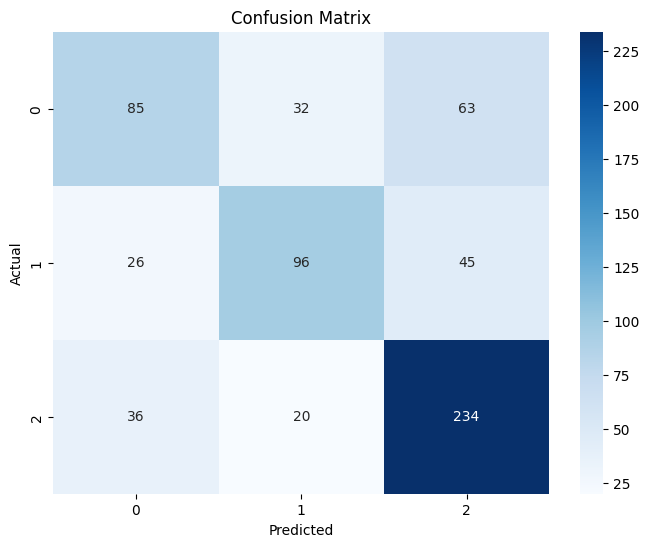

In [112]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

confusion = confusion_matrix(actual_labels, predicted_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', xticklabels=True, yticklabels=True)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()